In [1]:
#@title Importing Packages
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

#save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# load numpy array from npz file
from numpy import load

from tqdm import tqdm as tqdm

In [2]:
#@title Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Fashion MNIST

In [4]:
#@title Parameters

#DLGN(DLGN Model with only 3 linear layer containing 10,10,10 hidden nodes)
#DeepnonLinearModel(Model with only 3 non linear layer containing 10,10,10 hidden nodes)

#Replace any of the following in model_name to run that mode
#DLGN/DeepnonLinearModel
file_path = "/content/drive/MyDrive/Research/DLGN_Fashion_MNIST/Saved_models/"
file_name1 = "DLGN_95_full_black_patch_no_extra_data_lr_.001.npz"
error_file = "Error_DLGN_95_full_black_patch_no_extra_data_train_test_lr_.001.npz"

num_hidden_layers=3
input_dim=784
output_dim=10
num_hidden_nodes=[10,10,10]
modep='pwc'
model_name = 'DLGN' #@param {'type': 'string'}
batch_size = 64
beta = 20
epochs = 100
learning_rate = 0.001
optimizer_name ='SGD'
num_of_classes = 10 #10 -> using all 10 classes of FMNIST
n_corr_data = 95/100 #fraction of the data that is made corrupted
corrupted_train = True #True - fraction of the data is corrupted, False- expt on real data w.o corruption
corrupted_test = True
extra_data_train = False #True - Adding additional real data corresponding to the corrupted data, False- no addition
extra_data_test = False
simplified_patch_train = True #white patch and rest full black on train corrupted portion of the data
simplified_patch_test = True #white patch and rest full black on test corrupted portion of the data
model_training = True
model_inference = True
seed = 365

In [ ]:
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
set_npseed(seed)

**Load Dataset**

In [ ]:
#image transform and normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))])


#defining train and test sets.
trainset = torchvision.datasets.FashionMNIST('data',
                                             download=True,
                                             train=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('data',
                                            download=True,
                                            train=False,
                                            transform=transform)


**Important**

In [ ]:
# trainset.data[1][:4,:4]=0 can be used to access and modify the data from actual dataset downloaded in __init__

In [ ]:
# trainset[1][0][0][:4,:4] this is the data after transform that is used in training after taking index by index using __get_item()__ function and it is non-editable

In [ ]:
#@title 100% data + n_corr_data% corrupted data
#trainset
if extra_data_train:
  extra_train_data = torch.zeros(int(trainset.data.shape[0]*n_corr_data),trainset.data.shape[1],trainset.data.shape[2],dtype=torch.uint8)
  extra_train_target = torch.zeros(int(trainset.targets.shape[0]*n_corr_data),dtype=torch.int64)

  #testset
if extra_data_test:
  extra_test_data = torch.zeros(int(testset.data.shape[0]*n_corr_data),testset.data.shape[1],testset.data.shape[2],dtype=torch.uint8)
  extra_test_target = torch.zeros(int(testset.targets.shape[0]*n_corr_data),dtype=torch.int64)

In [ ]:
#@title **Left 4x4 n_corr_data% data 5 classes, right 4x4 n_corr_data% data for 5 classes**
if num_of_classes==10:
  if corrupted_train:
    #train_set
    count_corrupt = 0
    count = len(trainset)//10
    count_class= [0,0,0,0,0,0,0,0,0,0]
    for i in range(len(trainset)):
      data_class = trainset.targets[i].item()
      if((data_class<5)&(count_class[data_class]<count*n_corr_data)):
        if extra_data_train:
          extra_train_data[count_corrupt]=trainset.data[i].detach().clone()
          extra_train_target[count_corrupt]=trainset.targets[i].detach().clone()
          
          # print(extra_train_target[count_corrupt])
          count_corrupt=count_corrupt+1
        trainset.data[i][0+6*data_class:4+6*data_class,0:4]=255
        if simplified_patch_train:
          rest_black = torch.zeros(trainset.data[i].shape)
          rest_black[0+6*data_class:4+6*data_class,0:4]=255
          trainset.data[i] = rest_black
        trainset.targets[i]=(trainset.targets[i]+10) #added to differentiate the corrupted data from the uncorrupted data, corrupted data will have target value as target value+10
        count_class[data_class]+=1
      if((data_class>=5)&(count_class[data_class]<count*n_corr_data)):
        if extra_data_train:
          extra_train_data[count_corrupt]=trainset.data[i].detach().clone()
          extra_train_target[count_corrupt]=trainset.targets[i].detach().clone()
          count_corrupt=count_corrupt+1
        trainset.data[i][0+6*(data_class-5):4+6*(data_class-5),-4:]=255
        if simplified_patch_train:
          rest_black = torch.zeros(trainset.data[i].shape)
          rest_black[0+6*(data_class-5):4+6*(data_class-5),-4:]=255
          trainset.data[i] = rest_black
        trainset.targets[i]=(trainset.targets[i]+10)
        count_class[data_class]+=1

    #test_set
  if corrupted_test:
    count_corrupt_test = 0
    count_test = len(testset)//10
    count_class_test= [0,0,0,0,0,0,0,0,0,0]
    for i in range(len(testset)):
      data_class_test = testset.targets[i].item()
      if((data_class_test<5)&(count_class_test[data_class_test]<count_test*n_corr_data)):
        if extra_data_test:
          extra_test_data[count_corrupt_test]=testset.data[i].detach().clone()
          extra_test_target[count_corrupt_test]=testset.targets[i].detach().clone()
          count_corrupt_test=count_corrupt_test+1
        testset.data[i][0+6*data_class_test:4+6*data_class_test,0:4]=255
        if simplified_patch_test:
          rest_black = torch.zeros(testset.data[i].shape)
          rest_black[0+6*data_class_test:4+6*data_class_test,0:4]=255
          testset.data[i] = rest_black
        testset.targets[i]=(testset.targets[i]+10)
        count_class_test[data_class_test]+=1
      if((data_class_test>=5)&(count_class_test[data_class_test]<count_test*n_corr_data)):
        if extra_data_test:
          extra_test_data[count_corrupt_test]=testset.data[i].detach().clone()
          extra_test_target[count_corrupt_test]=testset.targets[i].detach().clone()
          count_corrupt_test=count_corrupt_test+1
        testset.data[i][0+6*(data_class_test-5):4+6*(data_class_test-5),-4:]=255
        if simplified_patch_test:
          rest_black = torch.zeros(testset.data[i].shape)
          rest_black[0+6*(data_class_test-5):4+6*(data_class_test-5),-4:]=255
          testset.data[i] = rest_black
        testset.targets[i]=(testset.targets[i]+10)
        count_class_test[data_class_test]+=1

In [ ]:
#@title Custom Dataset
class CustomDataset:
  def __init__(self,data,targets):
    self.data = data
    self.targets = targets
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,idx):
    current_sample = self.data[idx,:,:]
    current_target = self.targets[idx]
    return current_sample,current_target

In [ ]:
if extra_data_train:
  train_dataset_extra = CustomDataset(data=extra_train_data, targets= extra_train_target)
  trainset.data = torch.vstack([trainset.data,train_dataset_extra.data])
  trainset.targets = torch.cat([trainset.targets,train_dataset_extra.targets])

if extra_data_test:
  test_dataset_extra = CustomDataset(data=extra_test_data, targets= extra_test_target)
  testset.data = torch.vstack([testset.data,test_dataset_extra.data])
  testset.targets = torch.cat([testset.targets,test_dataset_extra.targets])

In [ ]:
#Creating dataloaders for both training and testing
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,
                                        shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = batch_size,
                                      shuffle=False)


In [ ]:
# #constant for different classes in the dataset
# classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat'
#       ,'Sandal','Shirt','Sneaker','Bag','Ankle Boot')

#function to show an image
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img=img.mean(dim=0)
  img = img/2 + 0.5 #unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [ ]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

**Visualizing Training Examples**

In [ ]:
dataiter = iter(trainloader)
images,labels = next(dataiter)
matplotlib_imshow(torchvision.utils.make_grid(images))

In [ ]:
print(labels)

In [ ]:
#@title **DLGN_FC**
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=784, output_dim=10, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False,device=device).to(device))
    else:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].cpu().weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].cpu().bias.detach().numpy()))
        self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].cpu().weight.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    x=x.view(x.shape[0],-1)
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape).to(device)]
    else:
      values=[x]
    for i in range(self.num_hidden_layers):
      gate_scores.append(self.gating_layers[i].to(device)(gate_scores[-1].to(device)).to(device))
      curr_gate_on_off = torch.sigmoid(beta*gate_scores[-1].to(device)).to(device)
      values.append(self.value_layers[i].to(device)(values[-1].to(device)).to(device)*curr_gate_on_off.to(device))
    values.append(self.value_layers[self.num_hidden_layers].to(device)(values[-1].to(device)).to(device))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores

**DNN Architecture**

In [ ]:
#@title **DNL_FC**
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DNL_FC(nn.Module):
  def __init__(self, to_copy=None, num_hidden_layers=0, input_dim=784, output_dim=10, num_hidden_nodes=[]):
    super(DNL_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
    else:
      self.gating_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1],device=device).to(device))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].cpu().weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].cpu().bias.detach().numpy()))

                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    x=x.view(x.shape[0],-1)
    gate_scores=[x]
    
    for i in range(self.num_hidden_layers):
      gate_scores.append(F.relu(self.gating_layers[i].to(device)(gate_scores[-1].to(device)).to(device)))
    gate_scores.append(F.log_softmax(self.gating_layers[self.num_hidden_layers].to(device)(gate_scores[-1].to(device)).to(device),dim=1))
    return gate_scores

In [ ]:
#@title **Train model**
def train_model(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,batch_size,mode,num_epoch):
  set_torchseed(seed)
  Model_obj = None
  
  if model_name == 'DLGN':
    Model_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)     
    
 
  if model_name == 'DeepnonLinearModel':
    Model_obj = DNL_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes)    
  
  Model_obj=Model_obj.to(device) 

  
  Model_params = []
  Model_params += [item.weight for item in Model_obj.gating_layers]
  Model_params += [item.bias for item in Model_obj.gating_layers]
  if model_name == 'DLGN':
    Model_params += [item.weight for item in Model_obj.value_layers]

  
 
  if optimizer_name == 'SGD':
    optimizer = optim.SGD(Model_params, lr=learning_rate)
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(Model_params, lr=learning_rate)

  criterion = nn.NLLLoss()
 
  losses=[]
  Model_obj_store = []
  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    if model_name == 'DLGN':
      Model_obj_store.append(DLGN_FC(to_copy=Model_obj))
    if model_name == 'DeepnonLinearModel':
      Model_obj_store.append(DNL_FC(to_copy=Model_obj))
    
    for images,labels in trainloader:
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      
      if model_name == 'DLGN':
        values,gate_scores = Model_obj(images)
        loss = criterion(F.log_softmax(values[-1],dim=1),labels%10)
      if model_name == 'DeepnonLinearModel':
        gate_scores = Model_obj(images)
        loss = criterion(gate_scores[-1],labels%10)
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item()    
    losses.append(running_loss/len(trainloader))

  return losses, Model_obj_store

In [ ]:
if model_training:
  losses, model_store = train_model(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,batch_size,
                  modep,epochs)

  # save to npy file
  file_name=file_path+file_name1
  savez_compressed(file_name, losses, model_store)

In [ ]:
#@title Inference Loop
def eval_fun(corrupted,data_loader,model):
  total = 0
  correct = 0

  if corrupted:
    total_corrupted = 0
    correct_corrupted = 0
    total_real = 0
    correct_real = 0

  #evaluation
  model.eval()
  with torch.no_grad():
    for images,labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      if model_name == 'DLGN':
        values,gate_scores = model(images)
        max_index = torch.argmax(F.log_softmax(values[-1],dim=1),dim=1)
      if model_name == 'DeepnonLinearModel':
        gate_scores = model(images)
        max_index = torch.argmax(gate_scores[-1],dim=1)
      total+=labels.numel()
      correct+=sum(max_index==(labels%10)).item()

    #For separate corrupted and real train images
      if corrupted:
        idx_corr=labels>9
        total_corrupted += idx_corr.sum().item()
        correct_corrupted+=(sum((labels[idx_corr]%10)==max_index[idx_corr]))
        idx_real=labels<=9
        total_real+=idx_real.sum().item()
        correct_real+=sum((labels[idx_real]%10)==max_index[idx_real])
        # for lb in range(len(labels)):
        #   if(labels[lb]>9):
        #     total_corrupted+=1
        #     correct_corrupted+=((labels[lb]%10)==max_index[lb]).item()
        #   else:
        #     total_real+=1
        #     correct_real+=((labels[lb]%10)==max_index[lb]).item()
    loss_z_o = (total-correct)/(total)
    if corrupted:
      loss_z_o_corrupted = (total_corrupted-correct_corrupted)/(total_corrupted)
      loss_z_o_real = (total_real-correct_real)/(total_real)
      # print(total,total_corrupted,total_real)
      # print(correct,correct_corrupted,correct_real)
    acc=(correct/total*100)
  if corrupted:
    return acc,loss_z_o,loss_z_o_corrupted,loss_z_o_real
  else:
    return acc,loss_z_o


In [ ]:
if model_inference:
  max_epoch=0
  max_acc=0
  epoch_count = []
  train_error = []
  test_error = []

  if corrupted_train:
    train_corrupted_error = []
    train_real_error = []
  if corrupted_test:
    test_corrupted_error = []
    test_real_error = []


  file_name_load  = file_path + file_name1
  # load numpy array from npz file
  from numpy import load
  # load dict of arrays
  dict_data = load(file_name_load,allow_pickle=True)
  losses=dict_data['arr_0']
  model_store=dict_data['arr_1']
  
  for index in range(len(model_store)):
    model=model_store[index]
    #Calculating the error for training data
    if corrupted_train:
      acc,loss_z_o_train,loss_z_o_corrupted_train,loss_z_o_real_train = eval_fun(corrupted_train,trainloader,model)
    else:
      acc,loss_z_o_train = eval_fun(corrupted_train,trainloader,model)
    train_error.append(loss_z_o_train)
    if corrupted_train:
      train_corrupted_error.append(loss_z_o_corrupted_train)
      train_real_error.append(loss_z_o_real_train)

    # print(f"Epoch[{e}/{epochs}]: Training loss:{running_loss/1000}",end=" ")
    print(f"Epoch[{index}/{epochs}]: Training zero_one loss:{loss_z_o_train}")
    # print(f"Epoch[{e}/{epochs}]: Training zero_one corrupted image loss:{loss_z_o_corrupted_train}",end=" ")
    # print(f"Epoch[{e}/{epochs}]: Training zero_one real image loss:{loss_z_o_real_train}",end=" ")


    #Calculating the error for test data
    if corrupted_test:
      acc,loss_z_o_test,loss_z_o_corrupted_test,loss_z_o_real_test = eval_fun(corrupted_test,testloader,model)
    else:
      acc,loss_z_o_test = eval_fun(corrupted_test,testloader,model)
    test_error.append(loss_z_o_test)
    if corrupted_test:
      test_corrupted_error.append(loss_z_o_corrupted_test)
      test_real_error.append(loss_z_o_real_test)

    # print(f"Test Accuracy {acc:.2f}",end=" ")
    print(f"Test Error {loss_z_o_test}")
    # print(f"Test Error corrupted images {loss_z_o_corrupted_test}",end=" ")
    # print(f"Test Error real images {loss_z_o_real_test}")

    epoch_count.append(index)

    if(acc>max_acc):
      max_acc = acc
      max_epoch = index

  file_name_error=file_path+error_file
  if(corrupted_train and corrupted_test):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error)
  elif(corrupted_train):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error)
  elif(corrupted_test):
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error)
  else:
    savez_compressed(file_name_error, max_epoch,max_acc,epoch_count,train_error,test_error)



**RESULTS**

In [5]:
error1="Error_DLGN_no_patch_no_extra_data_train_test_lr_.001.npz"

error2="Error_DLGN_50_white_patch_no_extra_data_train_test_lr_.001.npz"
error3="Error_DLGN_50_white_patch_no_extra_data_train_lr_.001.npz"
error4="Error_DLGN_50_white_patch_extra_data_train_test_lr_.001.npz"
error41="Error_DLGN_50_white_patch_extra_data_train_test_lr_.0001.npz"

error5="Error_DLGN_50_full_black_patch_no_extra_data_train_test_lr_.001.npz"
error6="Error_DLGN_50_full_black_patch_no_extra_data_train_lr_.001.npz"

error7="Error_DLGN_95_white_patch_no_extra_data_train_test_lr_.001.npz"
error8="Error_DLGN_95_white_patch_extra_data_train_test_lr_.001.npz"
error81="Error_DLGN_95_white_patch_extra_data_train_test_lr_.0001.npz"

error9="Error_DLGN_95_full_black_patch_no_extra_data_train_test_lr_.001.npz"
error91="Error_DLGN_95_full_black_patch_no_extra_data_train_test_lr_.0001.npz"
error10="Error_DLGN_95_full_black_patch_no_extra_data_train_lr_.001.npz"


In [8]:
#@title load error file
def load_error_file(error_file):
  file_name_load_error = file_path+error_file
  dict_data_error = load(file_name_load_error,allow_pickle=True)

  if(corrupted_train and corrupted_test):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    train_corrupted_error=dict_data_error['arr_5']
    train_real_error=dict_data_error['arr_6']
    test_corrupted_error=dict_data_error['arr_7']
    test_real_error=dict_data_error['arr_8']
    return max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error

  elif(corrupted_train):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    train_corrupted_error=dict_data_error['arr_5']
    train_real_error=dict_data_error['arr_6']
    return max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error

  elif(corrupted_test):
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    test_corrupted_error=dict_data_error['arr_5']
    test_real_error=dict_data_error['arr_6']
    return max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error

  else:
    max_epoch=dict_data_error['arr_0'].item()
    max_acc=dict_data_error['arr_1'].item()
    epoch_count=dict_data_error['arr_2']
    train_error=dict_data_error['arr_3']
    test_error=dict_data_error['arr_4']
    return max_epoch,max_acc,epoch_count,train_error,test_error



In [9]:
corrupted_train = False 
corrupted_test = False

In [10]:
max_epoch1,max_acc1,epoch_count1,train_error1,test_error1=load_error_file(error1)

In [71]:
corrupted_train = True 
corrupted_test = True  #False -> 3,6,10
error_file = error6  #41,81,91,10

In [72]:
if(corrupted_train and corrupted_test):
  max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error,test_corrupted_error,test_real_error=load_error_file(error_file)

elif(corrupted_train):
  max_epoch,max_acc,epoch_count,train_error,test_error,train_corrupted_error,train_real_error=load_error_file(error_file)

elif(corrupted_test):
  max_epoch,max_acc,epoch_count,train_error,test_error,test_corrupted_error,test_real_error=load_error_file(error_file)

else:
  max_epoch,max_acc,epoch_count,train_error,test_error=load_error_file(error_file)



In [73]:
print(max_acc)
print(max_epoch)

84.49
81


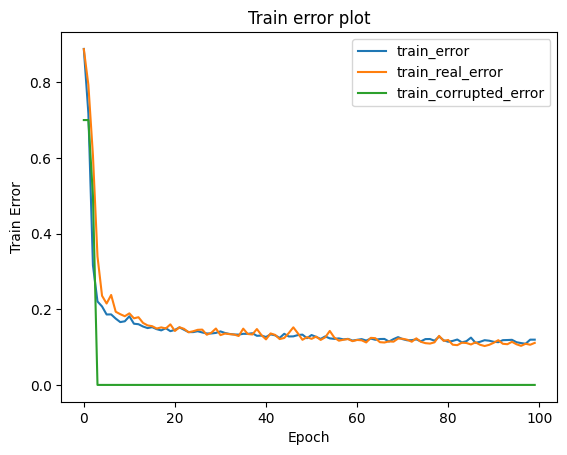

In [74]:
plt.figure()
plt.plot(train_error1[:],label="train_error")
if corrupted_train:
  plt.plot(train_real_error[:],label="train_real_error")
  plt.plot(train_corrupted_error[:],label="train_corrupted_error")
plt.xlabel('Epoch')
plt.ylabel('Train Error')
plt.title('Train error plot')
plt.legend()
plt.show()

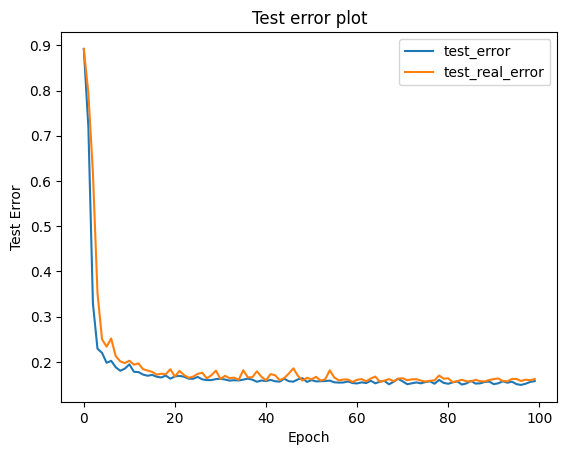

In [75]:
plt.figure()
plt.plot(test_error1[:],label="test_error")
if corrupted_test:
  plt.plot(test_real_error[:],label="test_real_error")
  plt.plot(test_corrupted_error[:],label="test_corrupted_error")
else:
  plt.plot(test_error[:],label="test_real_error")
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title('Test error plot')
plt.legend()
plt.show()

**ROUGH**